In [1]:

#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b90dfbeca7aad737f1790fa27f9abeb709c3175834886b75b03aad7f5403ce99
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 803.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s e

In [3]:

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam


## Model Definition

### Encoder, Decoder

In [14]:
class Encoder(nn.Module):
  def __init__(self,z_dim,hidden_dim):
    super().__init__()
    self.fc1 = nn.Linear(784,hidden_dim)
    self.fc21 = nn.Linear(hidden_dim,z_dim)
    self.fc22 = nn.Linear(hidden_dim,z_dim)
    #activation function
    self.softplus = nn.Softplus()

  #output mu and sigma of gaussian distribution
  def forward(self,x):
    x = x.reshape(-1,784)
    hidden = self.softplus(self.fc1(x))
    z_loc = self.fc21(hidden)
    z_scale = torch.exp(self.fc22(hidden))
    return z_loc,z_scale

class Decoder(nn.Module):
  def __init__(self,z_dim,hidden_dim):
    super().__init__()
    self.fc1 = nn.Linear(z_dim,hidden_dim)
    self.fc21 = nn.Linear(hidden_dim,784)
    self.softplus = nn.Softplus()

  #reconstruct image
  def forward(self,z):
    hidden = self.softplus(self.fc1(z))
    #output parameters of Bernoulli distribution
    loc_image = torch.sigmoid(self.fc21(hidden))
    return loc_image

### VAE

In [25]:
class VAE(nn.Module):
  def __init__(self,z_dim=2,hidden_dim=600,use_cuda=False):
    super().__init__()
    self.encoder = Encoder(z_dim,hidden_dim)
    self.decoder = Decoder(z_dim,hidden_dim)
    if use_cuda:
      self.cuda()
    self.use_cuda = use_cuda
    self.z_dim = z_dim

  def model(self,x):
    #parameter of Decoder should be optimized
    with pyro.plate("decoder",x.shape[0]):
      #prior distribution of z
      z_loc = torch.zeros(x.shape[0],self.z_dim,dtype=x.dtype,device=x.device)
      z_scale = torch.ones(x.shape[0],self.z_dim,dtype=x.dtype,device=x.device)
      #sample z
      z = pyro.sample("latent",dist.Normal(z_loc,z_scale).to_event(1))
      #make x from z
      loc_img = self.decoder.forward(z)
      pyro.sample("obs",dist.Bernoulli(loc_img,validate_args=False).to_event(1),obs=x.reshape(-1,784))
      return loc_img

  #set approximate function
  def guide(self,x):
    #parameter of encoder should be optimized
    with pyro.plate("encoder",x.shape[0]):
      #output parameters of z
      z_loc,z_scale = self.encoder.forward(x)
      #make z
      z = pyro.sample("latent",dist.Normal(z_loc,z_scale).to_event(1))

  #reconstruct image
  def reconstruct_img(self,x):
    z_loc,z_scale = self.encoder.forward(x)
    z = dist.Normal(z_loc,z_scale).sample()
    loc_img = self.decoder.foraward(z)
    return loc_img

## Train setting

In [27]:
from torchvision import datasets
from torchvision.transforms import ToTensor
#dataset
# 学習用
train_set  = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
# 検証用
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

cuda = False
jit=False #Just In Time
""" JIT compilers analyze the program's execution patterns and identify hotspots - portions of code that are frequently executed"""
learning_rate = 1.0e-3

#reset parameter
pyro.clear_param_store()

#make instance
vae = VAE(use_cuda=cuda)

#optimizer
adam_args = {"lr":learning_rate}
optimizer = Adam(adam_args)

#inference
elbo = JitTrace_ELBO() if jit else Trace_ELBO()
svi = SVI(vae.model,vae.guide,optimizer,elbo)

### Inference

In [20]:
train_elbo = []
num_epochs = 200
for epoch in range(num_epochs):
  epoch_loss = 0
  for x,t in train_loader:
    #print(x,t), x:input, t:output
    if cuda:
      x=x.cuda()
    epoch_loss += svi.step(x)

  normalizer_train = len(train_loader.dataset)
  total_epoch_loss_train = epoch_loss/normalizer_train
  train_elbo.append(total_epoch_loss_train)

/usr/local/lib/python3.10/dist-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'encoder'}
  warnings.warn(


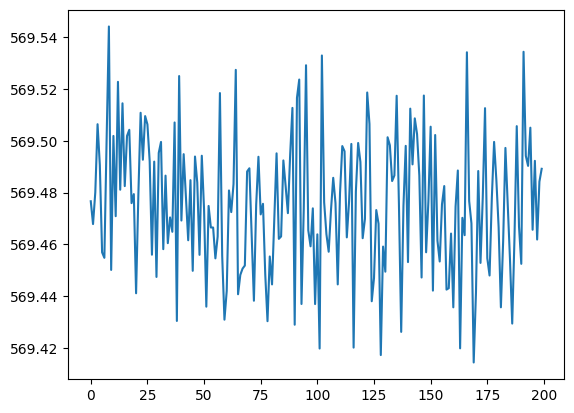

In [28]:
plt.plot(train_elbo)

### plot result

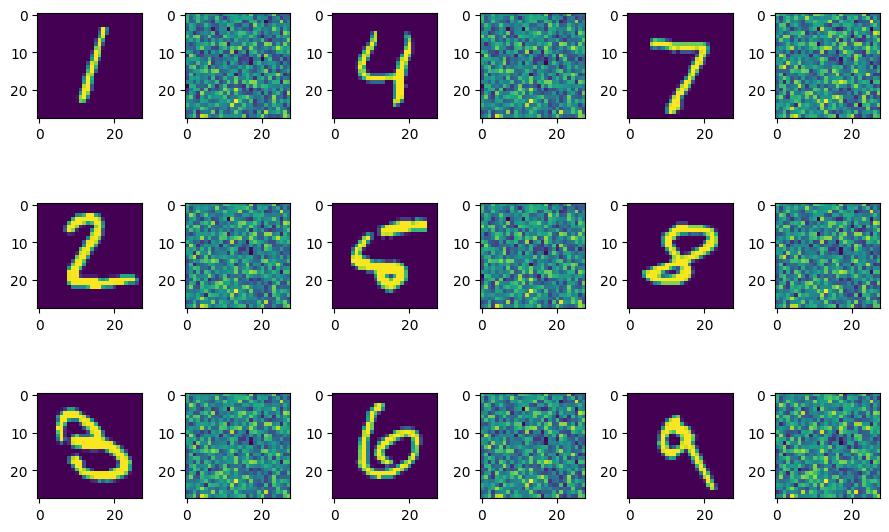

In [26]:
fig,ax = plt.subplots(ncols=6,nrows=3,figsize=(9,6))
need_labels = np.arange(1,10)
for i,(x,y) in enumerate(test_loader):
  if cuda:
    x = x.cuda()
  for index in range(x.shape[0]):

    test_img = x[index, :]
    test_label = y[index].item()

    if test_label in need_labels:
      # 1~10の画像を一つずつ使用するために可視化したラベルをタブーリストに追加
      need_labels = np.delete(need_labels, np.where(need_labels==test_label)[0])

      # 画像を再構成（エンコーダー→デコーダー）
      reco_img = vae.reconstruct_img(test_img)

      # 入力画像と変分自己符号化器で再構築した画像を可視化
      img_2D = test_img.reshape(28, 28).detach().cpu().numpy()
      reco_img_2D = reco_img.reshape(28, 28).detach().cpu().numpy()
      row_idx = test_label%3-1
      col_idx = (test_label-1)//3*2
      ax[row_idx, col_idx].imshow(img_2D)
      ax[row_idx, col_idx+1].imshow(reco_img_2D)
plt.tight_layout();


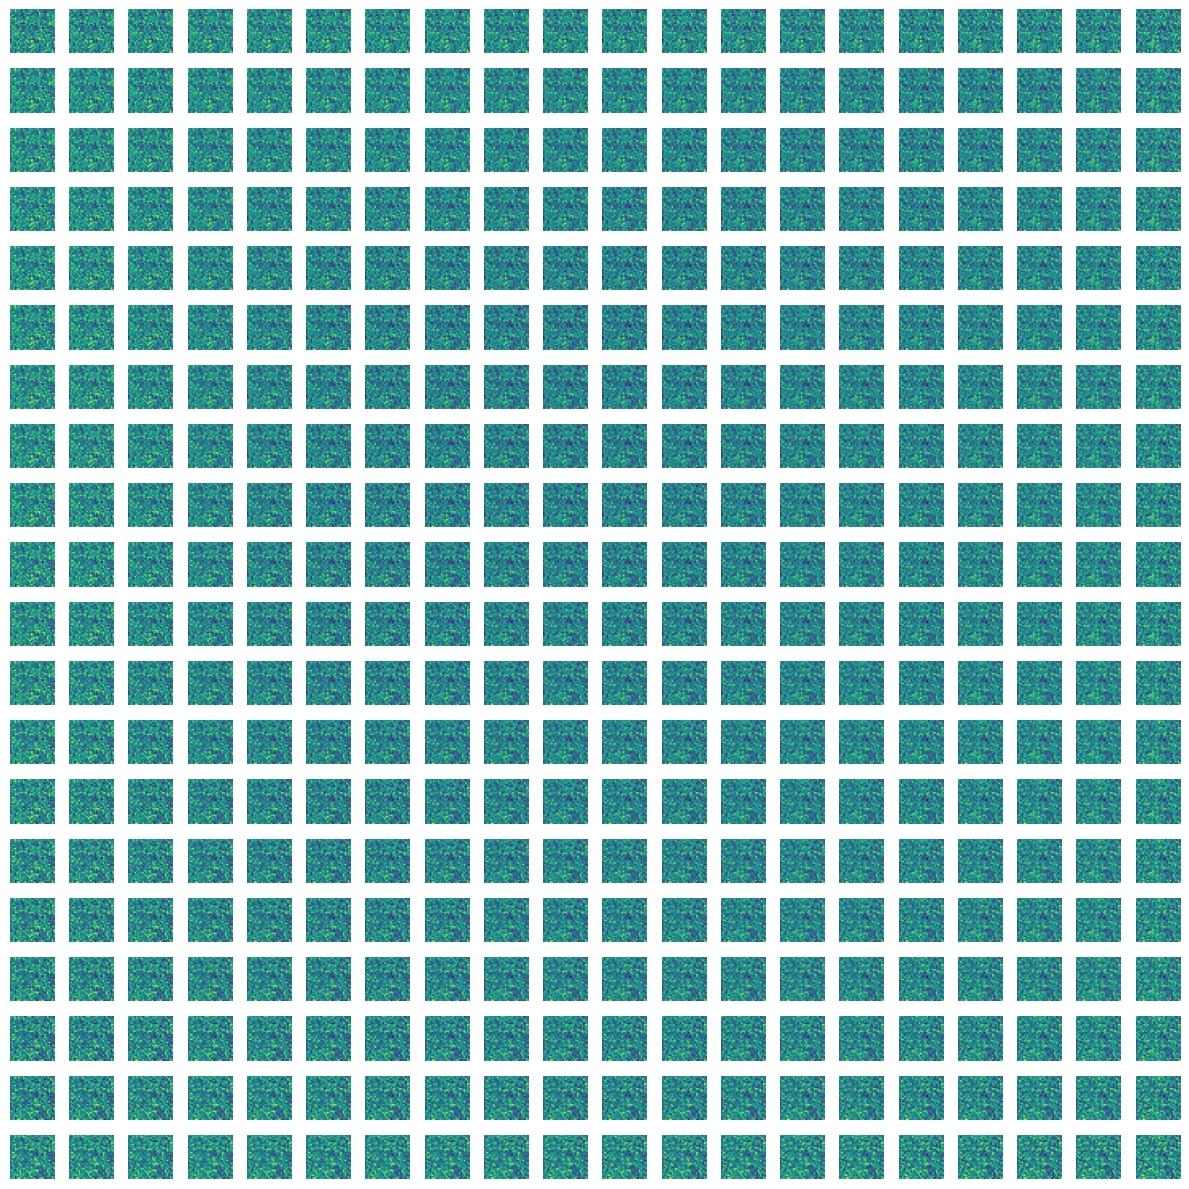

In [24]:
fig, ax = plt.subplots(figsize=(12, 12), ncols=20, nrows=20)
for idx1,x1 in enumerate(torch.linspace(0.01,0.99,20)):
    for idx2, x2 in enumerate(torch.linspace(0.01, 0.99,20)):

      # zをデコーダーに入力して、xを再構成
      z = torch.tensor([x1,x2])
      # 正規分布の累積密度関数の逆関数で変換
      z = torch.distributions.Normal(loc=0.0,scale=1.0).icdf(z)
      if cuda:
          z = z.cuda()
      # 画像の生成
      loc_img = vae.decoder(z)

      ax[idx1, idx2].imshow(loc_img.reshape(28, 28).detach().cpu().numpy())
      ax[idx1, idx2].axis('off')
plt.tight_layout();